In [1]:
%load_ext autoreload
%autoreload 2

# Exploratory analysis of the datasets

![](https://user-images.githubusercontent.com/45664104/86419986-e932eb00-bccc-11ea-98e3-e1dcba512804.png)

## Basis

In [1]:
DS_PATH = "../datasets/supervisely"

In [3]:
# Clone the repo which contains essential functions
!git clone https://github.com/JinhangZhu/supervisely-to-darknet.git
import sys
sys.path.append('./supervisely-to-darknet')

fatal: destination path 'supervisely-to-darknet' already exists and is not an empty directory.


In [ ]:
# Extract the *.tar files downloaded from Supervisely dashboard
!python extract.py

In [3]:
# Libraries
from tqdm import tqdm
import os
# from convert import *
import json
import glob
import shutil
import numpy as np 
import random
import matplotlib.pyplot as plt

In [5]:
# Delete all separate classes.names within each person dataset
for p in tqdm(os.listdir(DS_PATH), desc='Person'):
    filepath = os.path.join(DS_PATH, p)
    if os.path.isdir(filepath):
        if os.path.isfile(filepath + './classes.names'):
            os.remove(filepath + './classes.names')

Person: 100%|██████████| 20/20 [00:00<00:00, 102.83it/s]


In [7]:
class_names = {}    # Class names for person

for p in os.listdir(DS_PATH):
    filepath = os.path.join(DS_PATH, p)
    # print('\nPerson {}: '.format(p), filepath)

    if os.path.isdir(filepath):
        # Read meta.json to get classes
        meta_path = filepath + os.sep + 'meta.json'
        if os.path.isfile(meta_path):
            classes, names_path = get_classes(meta_path, write=False)
            class_names[p] = classes
        else:
            print('There is no meta.json file for person ', p)

# Save class names of all datasets into json
# class_names_path = DS_PATH + './ds_class_names.json'
class_names_path = './ds_class_names.json'
print('\nSave labels for person/subset/images in {}.'.format(class_names_path))
with open(class_names_path, 'w') as fp:
    json.dump(class_names, fp, indent=4)

# Iterate over key/value pairs in dict and print them
for p, clss in class_names.items():
    print(p, ' : ', clss)


Save labels for person/subset/images in ./ds_class_names.json.
P01 :['hand', '1', 'left_hand', 'right_hand']
P02 :['hand']
P03 :['hand']
P04 :['hand']
P05 :['hand']
P06 :['hand']
P07 :['hand']
P08 :['hand']
P10 :['hand']
P12 :['hand']
P13 :['hand']
P14 :['hand']
P15 :['hand']
P16 :['hand']
P17 :['hand']
P19 :['hand']
P20 :['hand']
P21 :['hand']
P22 :['hand']
P23 :['hand']


可以看出来，整体的标注信息表明，这20个人的数据集里，只有第一个人的数据包含四种标签，其余所有人的数据都是只有`hand`的标签，也就是有手和无手的区别。
下一步看：

- 各个标签的数目/该数据集的**有**标注总数/照片总数

> 但是`1`这个标签实在是很奇怪，需要继续看。对于左右手的标签，我随便点开了几个标注文件，发现没有左右手的，可能也是个占小部分的标注，也需要拿出来看看，是哪些照片有这些小比例的标注，这个比例有多少？总数又是多少？

In [8]:
# # Read json of class names
# with open(class_names_path, 'r') as fp:
#     class_names = json.load(fp)

## Details and Visualisation

In [9]:
def get_subset_labels(sub_p_path):
    """Get the labels from a subset of a person.

    Argument:
        sub_p_path: the path of the subset. e.g. '../datasets/supervisely\\P23\\P23_01'
    
    Returns:
        sub_p_labels: a dictionary whose keys are image names, values are a list of tuples.
            Each tuple is a bounding box: (class_name, b_x_center, b_y_center, b_width, b_height)
    """
    sub_p_labels={}

    # Get all file real paths
    read_path = sub_p_path + os.sep
    ann_paths = sorted(glob.glob(read_path + 'ann/' + '*.json'))
    img_paths = sorted(glob.glob(read_path + 'img/' + '*.jpg'))

    # Import all json annotation files for images
    for (ann_path, img_path) in zip(ann_paths, img_paths):
        # Current image
        img_name = os.path.basename(img_path)[:-4]
        sub_p_labels[img_name] = []

        # Import json
        with open(ann_path) as ann_f:
            ann_data = json.load(ann_f)
        
        # Image size
        image_size = ann_data['size']   # dict: {'height': , 'width': }

        # Objects bounding boxes
        bboxes = ann_data['objects']
        if len(bboxes) != 0:    # With object(s)
            for bbox in bboxes:
                class_name = bbox['classTitle']
                corner_coords = bbox['points']['exterior']  # bbox corner coordinates in [[left, top], [right, bottom]]

                # Normalisation
                b_x_center = (corner_coords[0][0] + corner_coords[1][0]) / 2 / image_size['width']
                b_y_center = (corner_coords[0][1] + corner_coords[1][1]) / 2 / image_size['height']
                b_width = (corner_coords[1][0] - corner_coords[0][0]) / image_size['width']
                b_height = (corner_coords[1][1] - corner_coords[0][1]) / image_size['height']

                # Save bbox label as a tuple for the image
                sub_p_labels[img_name].append(
                    (
                        class_name,
                        round(b_x_center, 6),
                        round(b_y_center, 6),
                        round(b_width, 6),
                        round(b_height, 6)
                    )
                ) 
        
    return sub_p_labels

In [10]:
# Labels of all datasets of all person
# format:
# {
#   'person':{
#               'subset':{
#                           'image': [(*bbox attributes)]
#                        }                
#            }   
# }
labels = {}

# Collect all annotations into a single json
for p in tqdm(os.listdir(DS_PATH), desc='Person'):
    p_path = os.path.join(DS_PATH, p)

    if os.path.isdir(p_path): 
        labels[p] = {}   # 'person'

        for sub_p in os.listdir(p_path):
            sub_p_path = os.path.join(p_path, sub_p)

            if os.path.isdir(sub_p_path):
                labels[p][sub_p] = get_subset_labels(sub_p_path)    # 'subset'
                print(
                    "{} image-annotation pairs in subset {} of person {}".format(len(labels[p][sub_p]), sub_p, p)
                )

labels_path = 'labels.json'
print('\nSave labels for person/subset/images in {}.'.format(labels_path))
with open(labels_path, 'w') as fp:
    json.dump(labels, fp, indent=4)

Person:   0%|          | 0/20 [00:00<?, ?it/s]1004 image-annotation pairs in subset P01_02 of person P01
238 image-annotation pairs in subset P01_03 of person P01
984 image-annotation pairs in subset P01_06 of person P01
Person:   5%|▌         | 1/20 [00:04<01:20,  4.24s/it]2070 image-annotation pairs in subset P02_06 of person P02
134 image-annotation pairs in subset P02_08 of person P02
109 image-annotation pairs in subset P02_11 of person P02
Person:  10%|█         | 2/20 [00:06<01:04,  3.59s/it]219 image-annotation pairs in subset P03_06 of person P03
215 image-annotation pairs in subset P03_07 of person P03
106 image-annotation pairs in subset P03_11 of person P03
49 image-annotation pairs in subset P03_18 of person P03
195 image-annotation pairs in subset P03_27 of person P03
Person:  20%|██        | 4/20 [00:07<00:33,  2.07s/it]777 image-annotation pairs in subset P05_04 of person P05
312 image-annotation pairs in subset P05_05 of person P05
Person:  25%|██▌       | 5/20 [00:08<

找到少数类的标注所在的图片|以及数目|以及总数

In [11]:
def find_annotation(labels, annotation):
    r_with_anno = False
    for p, p_labels in labels.items():
        for sub_p, sub_p_labels in p_labels.items():

            imgs_with_anno = []
            for img_name, bboxes in sub_p_labels.items():
                if len(bboxes) > 0:
                    for bbox in bboxes: # bbox: tuples of five attributes
                        if bbox[0] == annotation:
                            imgs_with_anno.append(img_name)
                            break
            
            if len(imgs_with_anno) > 0 and r_with_anno is False:
                r_with_anno = True  # There exists such an image with such annotation

            # print(
            #     "For subset {}, images with annotation '{}' count {}/{}.".format(sub_p, annotation, len(imgs_with_anno), len(sub_p_labels))#,
            # #    imgs_with_anno
            # )
    return r_with_anno

In [12]:
# Get all labels from class_names (for all person)
all_annotations = []
for clss in class_names.values():
    all_annotations.extend(clss)
all_annotations = set(all_annotations)
for annotation in all_annotations:
    if not find_annotation(labels, annotation):
        print("No image with annotation: '{}'".format(annotation))
    else:
        print("Image exists with annotation: '{}'".format(annotation))

No image with annotation: 'left_hand'
Image exists with annotation: 'hand'
No image with annotation: 'right_hand'
No image with annotation: '1'


现在问题很清晰了，第一个人的数据集根本没有我开始认为的少数标签：`1`, `left_hand`, `right_hand`，猜想是最开始设置了这些但是实际标注只标注了`hand`的标签。

所以得到一个结论：**这一次下载的所有的数据集都只有`hand`的标签**。可以把第一个人的`meta.json`的无用标签删掉了。

下一步，**数据清洗`hand`数据集，生成anchors，完成训练**。

In [13]:
del_labels = [l for l in all_annotations if l != 'hand']
print(del_labels)

['left_hand', 'right_hand', '1']


把含有无用标签的`meta.json`修改，去掉无用标签

In [14]:
def remove_labels(meta_path, del_labels):
    """Remove the specified labels from meta.json
    """
    with open(meta_path, 'r') as fp:
        meta_content = json.load(fp)
    
    rewrite = False
    classes = meta_content['classes']   # classes: list of dicts
    new_classes = []
    for cls_dict in classes:
        if cls_dict['title'] in del_labels:
            rewrite = True
        else:
            new_classes.append(cls_dict)
    
    if rewrite:
        meta_content['classes'] = new_classes
        print("Rewrote {} by deleting the labels: {}.".format(meta_path, del_labels))
        with open(meta_path, 'w') as fp:
            json.dump(meta_content, fp, indent=4)

In [15]:
for p in os.listdir(DS_PATH):
    filepath = os.path.join(DS_PATH, p)
    # print('\nPerson {}: '.format(p), filepath)

    if os.path.isdir(filepath):
        # Read meta.json to get classes
        meta_path = filepath + os.sep + 'meta.json'
        if os.path.isfile(meta_path):
            remove_labels(meta_path, del_labels)
        else:
            print('There is no meta.json file for person ', p)

Rewrote ../datasets/supervisely\P01\meta.json by deleting the labels: ['left_hand', 'right_hand', '1'].


In [16]:
# 检查一下数据集是不是清理干净了
# meta.json
class_names = {}    # Class names for person

for p in os.listdir(DS_PATH):
    filepath = os.path.join(DS_PATH, p)
    # print('\nPerson {}: '.format(p), filepath)

    if os.path.isdir(filepath):
        # Read meta.json to get classes
        meta_path = filepath + os.sep + 'meta.json'
        if os.path.isfile(meta_path):
            classes, names_path = get_classes(meta_path, write=False)
            class_names[p] = classes
        else:
            print('There is no meta.json file for person ', p)

# Save class names of all datasets into json
# class_names_path = DS_PATH + './ds_class_names.json'
class_names_path = './ds_class_names.json'
print('\nSave labels for person/subset/images in {}.'.format(class_names_path))
with open(class_names_path, 'w') as fp:
    json.dump(class_names, fp, indent=4)

# Iterate over key/value pairs in dict and print them
for p, clss in class_names.items():
    print(p, ' : ', clss)


Save labels for person/subset/images in ./ds_class_names.json.
P01 :['hand']
P02 :['hand']
P03 :['hand']
P04 :['hand']
P05 :['hand']
P06 :['hand']
P07 :['hand']
P08 :['hand']
P10 :['hand']
P12 :['hand']
P13 :['hand']
P14 :['hand']
P15 :['hand']
P16 :['hand']
P17 :['hand']
P19 :['hand']
P20 :['hand']
P21 :['hand']
P22 :['hand']
P23 :['hand']


In [45]:
# Get all labels from class_names (for all person)
all_annotations = []
for clss in class_names.values():
    all_annotations.extend(clss)
all_annotations = list(set(all_annotations))
all_annotations

['hand']

In [18]:
# Get all labels from class_names (for all person)
all_annotations = []
for clss in class_names.values():
    all_annotations.extend(clss)
all_annotations = set(all_annotations)
for annotation in all_annotations:
    if not find_annotation(labels, annotation):
        print("No image with annotation: '{}'".format(annotation))
    else:
        print("Image exists with annotation: '{}'".format(annotation))

Image exists with annotation: 'hand'


现在保证数据集是纯净的了，所有的图片有且仅有`hand`和没有`hand`两类，现在我们需要

**划分训练集，验证集和测试集**。

先把各个person的subsets混合

在`../datasets`目录下创建`handset`目录，其中包含所有的person的目录`P01`-`P23`这样的。每一个person的目录下包含`images`和`labels`两个目录和一个文件`meta.json`。即
```bash
├───handset
├───├───P01
├───├───├───images
├───├───├───labels
├───├───├───meta.json
├───├───P02
...
```

In [35]:
CONVERTED_PATH = '../datasets/handset'  # The path to the handset

In [36]:
# Make person(images and labels) folders
with open('labels.json', 'r') as fp:
    labels = json.load(fp)

for p, p_set in tqdm(labels.items(), desc='Person'):
    make_folders(
        path=CONVERTED_PATH + os.sep + p    # like handset/person/images
    )



Person:   0%|          | 0/20 [00:00<?, ?it/s]

Person:  10%|█         | 2/20 [00:41<06:14, 20.83s/it]

Person:  15%|█▌        | 3/20 [01:07<06:20, 22.39s/it]

Person:  20%|██        | 4/20 [01:22<05:21, 20.08s/it]

Person:  25%|██▌       | 5/20 [01:35<04:27, 17.84s/it]

Person:  30%|███       | 6/20 [02:11<05:28, 23.50s/it]

Person:  35%|███▌      | 7/20 [02:32<04:55, 22.73s/it]

Person:  40%|████      | 8/20 [02:52<04:22, 21.90s/it]

Person:  45%|████▌     | 9/20 [03:27<04:45, 25.91s/it]

Person:  50%|█████     | 10/20 [03:38<03:31, 21.18s/it]

Person:  55%|█████▌    | 11/20 [03:42<02:26, 16.29s/it]

Person:  60%|██████    | 12/20 [03:48<01:44, 13.11s/it]

Person:  65%|██████▌   | 13/20 [03:52<01:12, 10.32s/it]

Person:  70%|███████   | 14/20 [04:05<01:06, 11.15s/it]

Person:  75%|███████▌  | 15/20 [04:12<00:48,  9.77s/it]

Person:  80%|████████  | 16/20 [04:19<00:35,  8.94s/it]

Person:  85%|████████▌ | 17/20 [04:28<00:27,  9.17s/it]

Person:  90%|█████████ | 18/20 [04:53<00:27, 1

In [47]:
# Copy the images to there
# But change the image name as subset_index.jpg such as P01_02_0000000001.jpg
for p, p_set in tqdm(labels.items(), desc='Person'):
    for sub_p, sub_p_set in p_set.items():
        for img_name, bboxes in sub_p_set.items():
            if len(bboxes) != 0:    # There is >=1 bboxes
                # Reset file name
                # image_path = CONVERTED_PATH + '/' + p + '/images/'
                # label_path = CONVERTED_PATH + '/' + p + '/labels/'
                image_path = os.path.join(CONVERTED_PATH, p, 'images/')
                label_path = os.path.join(CONVERTED_PATH, p, 'labels/')
                image_name = sub_p + '_' + img_name + '.jpg'
                label_name = sub_p + '_' + img_name + '.txt'

                # Move image to the folder
                # curr_image_path = DS_PATH + os.sep + p + os.sep + sub_p + '/img/' + img_name + '.jpg'
                curr_image_path = os.path.join(DS_PATH, p, sub_p, 'img', img_name + '.jpg')
                shutil.copy(curr_image_path, image_path)
                # Rename
                os.rename(os.path.join(image_path, img_name+'.jpg'), os.path.join(image_path, image_name))
                
                for bbox in bboxes: # Each bbox: [class_name, b_x_center, b_y_center, b_width, b_height]
                    # Get attributes
                    class_index = all_annotations.index(bbox[0])
                    b_x_center, b_y_center, b_width, b_height = bbox[1:]

                    # Write labels file
                    if (b_width > 0.) and (b_height > 0.):
                        with open(label_path + label_name, 'a') as label_f:
                            label_f.write('%d %.6f %.6f %.6f %.6f\n' % (class_index, b_x_center, b_y_center, b_width, b_height))




Person:   0%|          | 0/20 [00:00<?, ?it/s]


Person:   5%|▌         | 1/20 [07:16<2:18:14, 436.56s/it]


Person:  10%|█         | 2/20 [08:54<1:40:31, 335.09s/it]


Person:  15%|█▌        | 3/20 [09:55<1:11:35, 252.67s/it]


Person:  20%|██        | 4/20 [10:37<50:31, 189.46s/it]


Person:  25%|██▌       | 5/20 [11:41<38:00, 152.00s/it]


Person:  30%|███       | 6/20 [18:02<51:30, 220.75s/it]


Person:  35%|███▌      | 7/20 [20:59<44:57, 207.49s/it]


Person:  40%|████      | 8/20 [24:01<39:58, 199.91s/it]


Person:  45%|████▌     | 9/20 [29:06<42:26, 231.46s/it]


Person:  50%|█████     | 10/20 [30:42<31:47, 190.79s/it]


Person:  55%|█████▌    | 11/20 [31:28<22:04, 147.20s/it]


Person:  60%|██████    | 12/20 [32:16<15:40, 117.56s/it]


Person:  65%|██████▌   | 13/20 [32:54<10:54, 93.54s/it]


Person:  70%|███████   | 14/20 [34:43<09:50, 98.35s/it]


Person:  75%|███████▌  | 15/20 [35:17<06:35, 79.11s/it]


Person:  80%|████████  | 16/20 [36:17<04:53, 73.25s/it]


Person:  85

In [111]:
# test shutil.copy and os.rename
with open('test.txt', 'w') as fp:
    fp.write('Hello world!')

dest_dir = os.mkdir('dest')
dest_dir = 'dest'

shutil.copy('test.txt', dest_dir)
dest_file = os.path.join(dest_dir, 'test.txt')
new_dst_file_name = os.path.join(dest_dir, 'yes.txt')
os.rename(dest_file, new_dst_file_name)

In [126]:
# Write classes.names 
with open(os.path.join(CONVERTED_PATH, 'classes.names'), 'w') as nf:
    nf.write('{}\n'.format('hand'))
shutil.copy(os.path.join(CONVERTED_PATH, 'classes.names'), os.getcwd())

'f:\\PROJECT\\project-diary\\classes.names'

现在我已经有了所有的数据集，按person划分，以及写有唯一标签`hand`的文件`classes.names`。现在需要进行**数据集的划分**，有两种思路可以实践：

1. 将所有person的数据集混合在一起，也就是把图片放在同一文件夹里面。然后随机打乱，去除一定比例的训练集，验证集和测试集；

2. 不混合person的数据集，而是随机选择一定比例的person，将他们的数据集分别混合在一起，作为训练集，验证集和测试集。

第一种方式操作起来很粗暴简单，但是会把所有人的图片混合在一起，随机取出之后各个subsets之间差别不大，在训练集上训练好的模型在测试集上可能一样表现很好，对于检测并提高模型的generalization没有帮助。因为每个人拍照的方式都会不同，数据集之间会存在一些特征差异，如果subsets各采用不同人群的数据会好一些。

In [22]:
def get_file_paths(directory):
    """Get paths to all files (NOT folders) in a directory.
    """
    file_paths = []
    for p in os.listdir(directory):
        p_path = os.path.join(directory, p)
        if os.path.isfile(p_path):
            file_paths.append(p_path)
    return file_paths

In [23]:
def get_folder_paths(directory):
    """Get paths to all folders (NOT files) in a directory.
    """
    folder_paths = []
    for p in os.listdir(directory):
        p_path = os.path.join(directory, p)
        if os.path.isdir(p_path):
            folder_paths.append(p_path)
    return folder_paths

In [24]:
# Get the lists of paths to all person datasets
p_paths = get_folder_paths(CONVERTED_PATH)

In [25]:
p_paths

['../datasets/handset\\P01',
 '../datasets/handset\\P02',
 '../datasets/handset\\P03',
 '../datasets/handset\\P04',
 '../datasets/handset\\P05',
 '../datasets/handset\\P06',
 '../datasets/handset\\P07',
 '../datasets/handset\\P08',
 '../datasets/handset\\P10',
 '../datasets/handset\\P12',
 '../datasets/handset\\P13',
 '../datasets/handset\\P14',
 '../datasets/handset\\P15',
 '../datasets/handset\\P16',
 '../datasets/handset\\P17',
 '../datasets/handset\\P19',
 '../datasets/handset\\P20',
 '../datasets/handset\\P21',
 '../datasets/handset\\P22',
 '../datasets/handset\\P23']

In [26]:
# random seed
SEED = 12345678
random.seed(SEED)
np.random.seed(SEED)

In [27]:
# Get the indices of person for training set, validation set and test set
train_ids, val_ids, test_ids = split_indices(
    data=p_paths,
    train_ratio=0.6,
    val_ratio=0.2,
    shuffle=True
)
datasets = {'train': train_ids, 'validation': val_ids, 'test': test_ids}

In [28]:
datasets

{'train': array([17,  5, 12,  3,  0, 13,  7,  9, 14, 10,  6, 15]),
 'validation': array([18,  8,  1, 11]),
 'test': array([16,  4,  2, 19])}

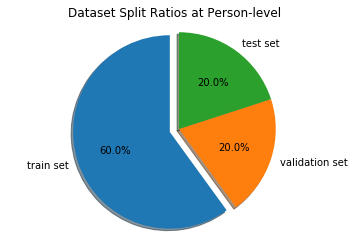

In [17]:
labels = [l+' set' for l in datasets.keys()]
sizes = [ss.size for ss in datasets.values()]
explode = (0.1, 0, 0)  # only "explode" the 1st slice (i.e. 'train')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Dataset Split Ratios at Person-level")

fig1.savefig("./images/dataset-split-person-level.png")
plt.show()

In [18]:
# Mix datasets of individuals for each subset
FINAL_PATH = '../datasets/ego-hand'

In [159]:
# Make images and labels folders
make_folders(FINAL_PATH)
shutil.copy(os.path.join(CONVERTED_PATH, 'classes.names'), FINAL_PATH)

'../datasets/ego-hand\\classes.names'

现在想了想，最后也还是得把所有照片混在一起，只要指明训练集/验证集/测试集还是按人分就行。

In [53]:
from_paths = get_folder_paths(CONVERTED_PATH)
from_paths

['../datasets/handset\\P01',
 '../datasets/handset\\P02',
 '../datasets/handset\\P03',
 '../datasets/handset\\P04',
 '../datasets/handset\\P05',
 '../datasets/handset\\P06',
 '../datasets/handset\\P07',
 '../datasets/handset\\P08',
 '../datasets/handset\\P10',
 '../datasets/handset\\P12',
 '../datasets/handset\\P13',
 '../datasets/handset\\P14',
 '../datasets/handset\\P15',
 '../datasets/handset\\P16',
 '../datasets/handset\\P17',
 '../datasets/handset\\P19',
 '../datasets/handset\\P20',
 '../datasets/handset\\P21',
 '../datasets/handset\\P22',
 '../datasets/handset\\P23']

In [64]:
# Transfer from handset to ego-hand
for key, ids in tqdm(datasets.items(), desc='Subsets'):
    if ids.any():   # Subsets not empty
        for p_path in [from_paths[i] for i in ids]:
            img_paths = sorted(glob.glob(p_path + '/images/' + '*.jpg'))
            ann_paths = sorted(glob.glob(p_path + '/labels/' + '*.txt'))
            for img_path, ann_path in zip(img_paths, ann_paths):
                shutil.copy(img_path, os.path.join(FINAL_PATH, 'images'))   # Copy an image
                shutil.copy(ann_path, os.path.join(FINAL_PATH, 'labels'))   # Copy a label




Subsets:   0%|          | 0/3 [00:00<?, ?it/s]


Subsets:  33%|███▎      | 1/3 [25:32<51:04, 1532.46s/it]


Subsets:  67%|██████▋   | 2/3 [37:23<21:26, 1286.16s/it]


Subsets: 100%|██████████| 3/3 [43:13<00:00, 864.44s/it]


In [70]:
os.path.basename(from_paths[0])

'P01'

In [72]:
# Store the paths of subsets *.txt files
subsets_paths = {}
for key, ids in tqdm(datasets.items(), desc='Subsets'):
    if ids.any():
        subsets_paths[key] = os.path.join(FINAL_PATH, key + '.txt')  # Store the key/path
        with open(subsets_paths[key], 'a') as wf:
            for idx in ids: # idx: index of person
                p_path = from_paths[idx]
                img_paths = sorted(glob.glob(p_path + '/images/' + '*.jpg'))
                for img_path in img_paths:
                    write_name = os.path.join(FINAL_PATH, 'images', os.path.basename(img_path))
                    wf.write('{}'.format(write_name) + '\n')




Subsets:   0%|          | 0/3 [00:00<?, ?it/s]


Subsets:  33%|███▎      | 1/3 [00:04<00:09,  4.88s/it]


Subsets:  67%|██████▋   | 2/3 [00:05<00:03,  3.49s/it]


Subsets: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


In [76]:
 # Write .data file
 with open(os.path.join(FINAL_PATH, os.path.basename(FINAL_PATH)) + '.data', 'a') as data_f:
    data_f.write('classes={}\n'.format(len(classes)))   # Classes count
    data_f.write('train={}\n'.format(subsets_paths['train']))   # Path of train set
    data_f.write('valid={}\n'.format(subsets_paths['validation'])) # Path of validation set
    data_f.write('names={}\n'.format(os.path.join(FINAL_PATH, 'classes.names')))   # Path of .names file

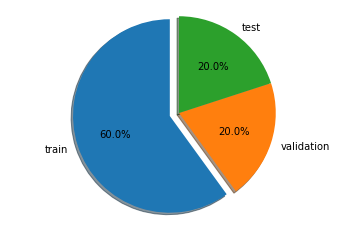

In [83]:
# Visualise subsets information
subsets = [l for l in datasets.keys()]
sizes = [ss.size for ss in datasets.values()]
explode = (0.1, 0, 0)  # only "explode" the 1st slice (i.e. 'train')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=subsets, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

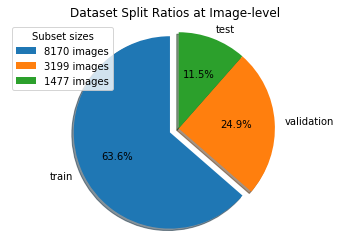

In [22]:
datasets_images = {}
for subset in subsets:
    with open(os.path.join(FINAL_PATH, subset+'.txt'), 'r') as f:
        datasets_images[subset] = f.read().split('\n')[:-1]
sizes = [len(ss) for ss in datasets_images.values()]
explode = (0.1, 0, 0)  # only "explode" the 1st slice (i.e. 'train')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=subsets, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend([str(s)+ ' images' for s in sizes], title='Subset sizes', loc='best')
plt.title("Dataset Split Ratios at Image-level")

fig1.savefig("./images/dataset-split-image-level.png")
plt.show()

现在已经把数据集全部做好了，不过每一个subset里面，图片基本是按照person的顺序来的，现在再来给它打乱一下。

In [108]:
for subset, img_paths in datasets_images.items():
    with open(os.path.join(FINAL_PATH, subset+'.txt'), 'w') as wf:
        random.shuffle(img_paths)
        for ip in img_paths:
            wf.write('{}\n'.format(ip))

现在的`ego-hand`数据集的结构：



In [109]:
names = os.listdir(FINAL_PATH)
for i in names:
    path = os.path.join(FINAL_PATH, i)
    print(path)

../datasets/ego-hand\classes.names
../datasets/ego-hand\ego-hand.data
../datasets/ego-hand\images
../datasets/ego-hand\labels
../datasets/ego-hand\test.txt
../datasets/ego-hand\train.txt
../datasets/ego-hand\validation.txt


## 数据集综合分析

In [4]:
PATH = '../datasets/epichands'

In [9]:
# Egohands: hand
with open(os.path.join(PATH, 'train.txt'), 'r') as f:
    lines = f.readlines()
    print('train: {}'.format(len(lines)))
with open(os.path.join(PATH, 'validation.txt'), 'r') as f:
    lines = f.readlines()
    print('validation: {}'.format(len(lines)))
with open(os.path.join(PATH, 'test.txt'), 'r') as f:
    lines = f.readlines()
    print('test: {}'.format(len(lines)))

img_paths = sorted(glob.glob(os.path.join(PATH, 'images/' + '*.jpg')))
ann_paths = sorted(glob.glob(os.path.join(PATH, 'labels/' + '*.txt')))
print('Images: {}'.format(len(img_paths)))

n_hands = 0
for ann_path in ann_paths:
    with open(ann_path, 'r') as f:
        boxes = f.readlines()
        n_hands += len(boxes)
print('Num of hands: {}'.format(n_hands))

train: 8166
validation: 3195
test: 1476
Images: 12837
Num of hands: 21860


In [11]:
# Epichands: l, r
n_lhands = 0
n_rhands = 0
for ann_path in ann_paths:
    with open(ann_path, 'r') as f:
        for line in f:
            line = line[:-1].split()
            if int(line[0]) == 0:
                n_lhands += 1
            else:
                n_rhands += 1   
print(
    'Num of left hands: {}\n'.format(n_lhands),
    'Num of right hands: {}\n'.format(n_rhands)
)

Num of left hands: 10529
Num of right hands: 11331



In [12]:
# Epichands_mixed: l, r
with open(os.path.join(PATH, 'epichands_mixed/train.txt'), 'r') as f:
    lines = f.readlines()
    print('train: {}'.format(len(lines)))
with open(os.path.join(PATH, 'epichands_mixed/validation.txt'), 'r') as f:
    lines = f.readlines()
    print('validation: {}'.format(len(lines)))
with open(os.path.join(PATH, 'epichands_mixed/test.txt'), 'r') as f:
    lines = f.readlines()
    print('test: {}'.format(len(lines)))

train: 7702
validation: 2567
test: 2567


In [14]:
# P30: l, r
PATH = '../datasets/P30'
with open(os.path.join(PATH, 'P30_train.txt'), 'r') as f:
    lines = f.readlines()
    print('train: {}'.format(len(lines)))
with open(os.path.join(PATH, 'P30_validation.txt'), 'r') as f:
    lines = f.readlines()
    print('validation: {}'.format(len(lines)))
# with open(os.path.join(PATH, 'P30_test.txt'), 'r') as f:
#     lines = f.readlines()
#     print('test: {}'.format(len(lines)))

img_paths = sorted(glob.glob(os.path.join(PATH, 'images/' + '*.jpg')))
ann_paths = sorted(glob.glob(os.path.join(PATH, 'labels/' + '*.txt')))
print('Images: {}'.format(len(img_paths)))

n_lhands = 0
n_rhands = 0
for ann_path in ann_paths:
    with open(ann_path, 'r') as f:
        for line in f:
            line = line[:-1].split()
            if int(line[0]) == 0:
                n_lhands += 1
            else:
                n_rhands += 1   
print(
    'Num of left hands: {}\n'.format(n_lhands),
    'Num of right hands: {}\n'.format(n_rhands)
)

train: 679
validation: 75
Images: 754
Num of left hands: 593
Num of right hands: 468

